In [13]:
import os
import glob
import torch
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
train_list = pd.read_csv('./data/VOCdevkit/VOC2012/ImageSets/Main/train.txt', header=0, names=['filename'])['filename'].tolist()
val_list = pd.read_csv('./data/VOCdevkit/VOC2012/ImageSets/Main/val.txt', header=0, names=['filename'])['filename'].tolist()
train_img_list = [os.path.join('./data/VOCdevkit/VOC2012/JPEGImages', i+'.jpg') for i in train_list]
train_anno_list = [os.path.join('./data/VOCdevkit/VOC2012/Annotations', i+'.xml') for i in train_list]
val_img_list =  [os.path.join('./data/VOCdevkit/VOC2012/JPEGImages', i+'.jpg') for i in val_list]
val_anno_list = [os.path.join('./data/VOCdevkit/VOC2012/Annotations', i+'.xml') for i in val_list]
val_img_list[:10]

['./data/VOCdevkit/VOC2012/JPEGImages/2008_000003.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000007.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000016.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000021.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000026.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000027.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000032.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000034.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2008_000042.jpg']

In [6]:
# 「XML形式のアノテーション」を、リスト形式に変換するクラス


class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [9]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = train_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)


array([[0.        , 0.84191176, 0.88958333, 1.07352941, 3.        ]])

In [11]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)


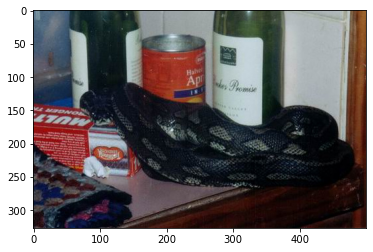

/mnt/c/Users/drago/github/machine-learning-study/作りながら学ぶPytorchによる発展ディープラーニング/1_1_image_classification/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


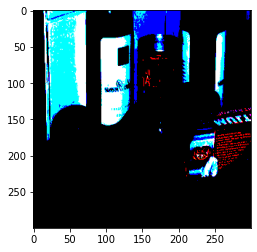

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


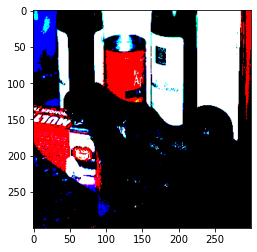

In [14]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
# [高さ][幅][色BGR]
# BGRという順番に注意
img = cv2.imread(image_file_path) 
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        pass

    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape

        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, :4])